In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.metrics import AUC
from sklearn.utils import shuffle
from PIL import Image


In [2]:
def calculate_shannon_entropy(image_path):
    """Calculate Shannon entropy for an image."""
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    histogram = np.array(image.histogram())  # Pixel intensity distribution
    histogram = histogram / histogram.sum()  # Normalize to probability distribution
    entropy = -np.sum(histogram * np.log2(histogram + 1e-9))  # Add small epsilon to avoid log(0)
    return entropy

In [ ]:
# Define paths
main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
sub_dirs = ['train', 'test', 'valid']

# Function to create DataFrame with entropy
def create_dataframe_with_entropy(main_path, sub_dir):
    data = {"file_path": [], "label": [], "entropy": []}
    for label_dir, label in zip(['real', 'fake'], [1, 0]):  # 'real' -> 1, 'fake' -> 0
        folder_path = os.path.join(main_path, sub_dir, label_dir)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            entropy = calculate_shannon_entropy(img_path)
            data["file_path"].append(img_path)
            data["label"].append(label)
            data["entropy"].append(entropy)
    return pd.DataFrame(data)

# Create CSVs with entropy
for sub_dir in sub_dirs:
    df = create_dataframe_with_entropy(main_path, sub_dir)
    df = shuffle(df, random_state=42).reset_index(drop=True)
    df.to_csv(f"{sub_dir}.csv", index=False)
    print(f"Saved {sub_dir}.csv with {len(df)} entries.")

Saved train.csv with 100000 entries.
Saved test.csv with 20000 entries.
Saved valid.csv with 20000 entries.


In [7]:
import pandas as pd
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, image_size, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[batch_indices]

        images = np.array([img_to_array(load_img(path, target_size=self.image_size)) / 255.0
                           for path in batch_data['file_path']])
        entropies = np.array(batch_data['entropy']).reshape(-1, 1)
        labels = np.array(batch_data['label']).astype('float32')

        return {'image_input': images, 'entropy_input': entropies}, labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Load DataFrames
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('valid.csv')
test_df = pd.read_csv('test.csv')

# Create Generators
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 64

train_gen = CustomDataGenerator(train_df, BATCH_SIZE, IMAGE_SIZE)
valid_gen = CustomDataGenerator(valid_df, BATCH_SIZE, IMAGE_SIZE, shuffle=False)
test_gen = CustomDataGenerator(test_df, BATCH_SIZE, IMAGE_SIZE, shuffle=False)

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Reshape, Dense, Multiply, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    image_input = Input(shape=(256, 256, 3), name='image_input')
    entropy_input = Input(shape=(1,), name='entropy_input')

    base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=image_input)

    for layer in base_model.layers[-20:]:
        layer.trainable = True

    se = GlobalAveragePooling2D()(base_model.output)
    se = Reshape((1, 1, se.shape[1]))(se)
    se = Dense(se.shape[-1] // 16, activation='relu')(se)            # Reduced channels: 1024 / 16 = 64
    se = Dense(base_model.output.shape[-1], activation='sigmoid')(se) # Match channels with base_model.output (1024)
    attention_output = Multiply()([base_model.output, se])            # Shapes are now compatible

    x = GlobalAveragePooling2D()(attention_output)
    combined = Concatenate()([x, entropy_input])
    x = Dense(512, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[image_input, entropy_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,697,537 (29.36 MB)

 Trainable params: 7,612,865 (29.04 MB)

 Non-trainable params: 84,672 (330.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Re-compile Model with New Optimizer
with strategy.scope():
    optimizer = tf.keras.optimizers.Adam()  # Re-initialize the optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Model Training
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.8284 - auc: 0.9005 - loss: 0.3928
Epoch 1: val_auc improved from -inf to 0.98327, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1745s 964ms/step - accuracy: 0.8284 - auc: 0.9005 - loss: 0.3927 - val_accuracy: 0.9041 - val_auc: 0.9833 - val_loss: 0.2595 - learning_rate: 0.0010
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.9649 - auc: 0.9942 - loss: 0.0933
Epoch 2: val_auc improved from 0.98327 to 0.98643, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1488s 951ms/step - accuracy: 0.9649 - auc: 0.9942 - loss: 0.0933 - val_accuracy: 0.9401 - val_auc: 0.9864 - val_loss: 0.1508 - learning_rate: 0.0010
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.9740 - auc: 0.9966 - loss: 0.0691
Epoch 3: val_auc did not improve from 0.98643
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1490s 952ms/step - accuracy: 0.9740 - auc: 0.9966 - loss: 0.0691 - val_accuracy: 0.9188 - val_auc

In [11]:
# Evaluate on Test Set
results = model.evaluate(test_gen)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")
print(f"Test AUC: {results[2]:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 248ms/step - accuracy: 0.9938 - auc: 0.9996 - loss: 0.0175
Test Loss: 0.0163
Test Accuracy: 99.41%
Test AUC: 0.9998


313/313 ━━━━━━━━━━━━━━━━━━━━ 75s 215ms/step


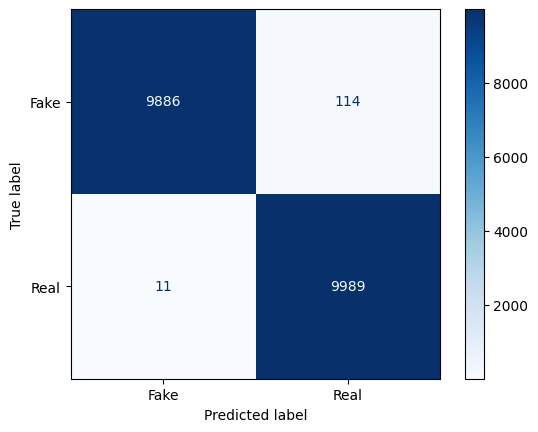

In [13]:
# Get true labels from the test DataFrame
y_true = test_df['label'].values

# Predict probabilities for the test set
y_pred_probs = model.predict(test_gen)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

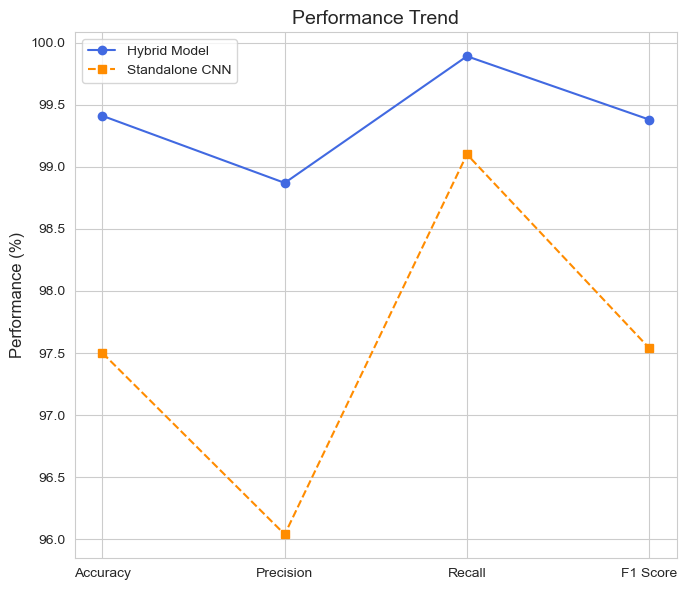

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Selected Metrics and values
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

hybrid_model = [99.41, 98.87, 99.89, 99.38]
standalone_cnn = [97.50, 96.04, 99.10, 97.54]

# Set seaborn style
sns.set_style("whitegrid")
plt.figure(figsize=(7, 6))

# Line plot for trend visualization
plt.plot(metrics, hybrid_model, marker='o', linestyle='-', color='royalblue', label='Hybrid Model')
plt.plot(metrics, standalone_cnn, marker='s', linestyle='--', color='darkorange', label='Standalone CNN')
plt.ylabel("Performance (%)", fontsize=12)
plt.title("Performance Trend", fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
